In [181]:
%load_ext autoreload
%autoreload 2
# from google.colab import drive
# drive.mount('/content/gdrive')
import os
import sys
# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/MyDrive/Projects/2023-HJ-Prox/src/')


sys.path.append('/home/sh2146/pinns')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
# # cd/content/gdrive/My Drive/pinns
# cd/home/sh2146/pinns

In [183]:
import argparse
import torch
import torch.nn as nn
import data
import utils
# import importlib
# importlib.reload(utils)
import model
import numpy as np
from tqdm import tqdm
import scipy.io
import matplotlib.pyplot as plt

### 1. Default Setting

1. Domain: 100 x 256 ($x \in [-1,1]$ and $t \in [0,1]$)

2. Collocation points: $N_{ic}=256$ and $N_{f}=25600$

3. Optimizer: Adam with the learning rate of $10^{-3}$


In [184]:
num_t = 100
num_x = 256
num_epochs = 20000
num_hidden = 4
num_nodes = 128
lr = 1e-2 #0.001

In [185]:
# Select a partial differential equation
# eq = 'ac'  or 'bg' or 'hj' or 'bshj'
eq = 'bshj'

### 2. Train Data

In [186]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Operation mode: ", device)

Operation mode:  cuda:1


In [187]:
if eq == 'bg':
    t_data, x_data, u_data, t_data_f, x_data_f = data.bg_generator(num_t, num_x)  
elif eq == 'ac':
    t_data, x_data, u_data, t_data_f, x_data_f = data.ac_generator(num_t, num_x)
elif eq == 'hj':
    t_data, x_data, u_data, t_data_f, x_data_f = data.hj_generator(num_t, num_x)
elif eq == 'bshj':
    t_data, x_data, u_data, t_data_f, x_data_f = data.bs_entropy_hj_generator(num_t, num_x)
else:
    print("There exists no the equation.")
    exit(0)
# print(eq)

In [188]:
variables = torch.FloatTensor(np.concatenate((t_data, x_data), 1)).to(device)
variables_f = torch.FloatTensor(np.concatenate((t_data_f, x_data_f), 1)).to(device)
variables_f.requires_grad = True
u_data = torch.FloatTensor(u_data).to(device)

### 3. Neural Network

In [189]:
layer_list = [2] + num_hidden * [num_nodes] + [1]
pinn = model.pinn(layer_list).to(device)

### 4. Training Session

In [190]:
optimizer = torch.optim.Adam(pinn.parameters(), betas=(0.999,0.999), lr=lr)
loss_graph = []
ls = 10
bep = 0

In [191]:
def hj_equation(u, tx):
    u_tx = fwd_gradients(u, tx)
    u_t = u_tx[:, 0:1]
    u_x = u_tx[:, 1:2]
    # e= u_t + 0.5* np.linalg.norm(u_x)**2
    e = u_t + 1/2*(u_x)**2
    return e

def bs_entropy_hj_equation(u, tx):
    u_tx = fwd_gradients(u, tx)
    u_t = u_tx[:, 0:1]
    u_x = u_tx[:, 1:2]
    t=tx[:,0:1]
    x=tx[:,1:2]
    e= u_t + 1/t**2 *((x-t/x*u_x*torch.log(1-t/x**2*u_x)+t/x*u_x))
    return e 


    
optimizer.zero_grad()

# Full batch
u_hat = pinn(variables)
u_hat_f = pinn(variables_f)

if eq == 'bg':
    loss_f = torch.mean(utils.burgers_equation(u_hat_f, variables_f) ** 2)
elif eq == 'ac':
    loss_f = torch.mean(utils.ac_equation(u_hat_f, variables_f) ** 2)
elif eq == 'hj':
    loss_f = torch.mean(utils.hj_equation(u_hat_f, variables_f) ** 2)
elif eq == 'bshj':
    loss_f = torch.mean(utils.bs_entropy_hj_equation(u_hat_f, variables_f) ** 2)

# utils.bs_entropy_hj_equation(u_hat_f, variables_f) ** 2
# loss_u = torch.mean((u_hat - u_data) ** 2)
loss = loss_f
# print(u_hat)
# print(u_hat_f)
# print(variables_f[:,0:1].shape)
# print(variables)
# print(variables_f)
print(loss.item())

0.020929140970110893


In [192]:
for ep in tqdm(range(num_epochs)):
        
        optimizer.zero_grad()
        
        # Full batch
        u_hat = pinn(variables)
        u_hat_f = pinn(variables_f)
        
        if eq == 'bg':
            loss_f = torch.mean(utils.burgers_equation(u_hat_f, variables_f) ** 2)
        elif eq == 'ac':
            loss_f = torch.mean(utils.ac_equation(u_hat_f, variables_f) ** 2)
        elif eq == 'hj':
            loss_f = torch.mean(utils.hj_equation(u_hat_f, variables_f) ** 2)
        elif eq == 'bshj':
            loss_f = torch.mean(utils.bs_entropy_hj_equation(u_hat_f, variables_f) ** 2)
        
        # loss_u = torch.mean((u_hat - u_data) ** 2)
        loss = loss_f  # + loss_u
        loss.backward() 
        optimizer.step()
        
        l = loss.item()
        loss_graph.append(l)
        if l < ls:
            ls = l
            bep = ep
            torch.save(pinn.state_dict(), './'+eq+'_1d.pth')
            
        if ep % 1000 == 0:
            print(f"Train loss: {l}") 

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 15/50000 [00:00<05:50, 142.76it/s]

Train loss: 0.020929140970110893


  2%|▏         | 1026/50000 [00:07<05:55, 137.81it/s]

Train loss: 0.015185871161520481


  4%|▍         | 2016/50000 [00:14<06:00, 132.97it/s]

Train loss: 0.022746553644537926


  6%|▌         | 3009/50000 [00:21<05:32, 141.32it/s]

Train loss: 0.0067861187271773815


  8%|▊         | 4025/50000 [00:28<05:56, 129.07it/s]

Train loss: 0.0004299799620639533


 10%|█         | 5023/50000 [00:36<05:17, 141.55it/s]

Train loss: 0.0003285952552687377


 12%|█▏        | 6011/50000 [00:43<05:12, 140.72it/s]

Train loss: 0.0004357591096777469


 14%|█▍        | 7026/50000 [00:50<05:06, 140.23it/s]

Train loss: 0.0002236315340269357


 16%|█▌        | 8025/50000 [00:57<04:53, 143.16it/s]

Train loss: 0.0001032945147017017


 18%|█▊        | 9016/50000 [01:04<04:51, 140.66it/s]

Train loss: 1.7146590835181996e-05


 20%|██        | 10025/50000 [01:12<04:53, 136.01it/s]

Train loss: 1.3761082300334238e-05


 22%|██▏       | 11014/50000 [01:19<04:47, 135.51it/s]

Train loss: 1.2536300346255302e-05


 24%|██▍       | 12018/50000 [01:26<04:31, 140.13it/s]

Train loss: 6.417918484658003e-06


 26%|██▌       | 13022/50000 [01:33<04:26, 138.72it/s]

Train loss: 3.946577180613531e-06


 28%|██▊       | 14018/50000 [01:40<04:24, 135.98it/s]

Train loss: 2.2788424303143984e-06


 30%|███       | 15021/50000 [01:48<04:21, 133.55it/s]

Train loss: 1.5135070725591504e-06


 32%|███▏      | 16018/50000 [01:55<04:03, 139.46it/s]

Train loss: 9.190416108140198e-07


 34%|███▍      | 17023/50000 [02:02<04:02, 136.21it/s]

Train loss: 6.451517720051925e-07


 36%|███▌      | 18019/50000 [02:10<03:55, 136.07it/s]

Train loss: 5.23555172549095e-07


 38%|███▊      | 19024/50000 [02:17<04:03, 127.03it/s]

Train loss: 3.397278476313659e-07


 40%|████      | 20016/50000 [02:25<04:06, 121.61it/s]

Train loss: 2.265786633870448e-07


 42%|████▏     | 21021/50000 [02:33<03:39, 131.80it/s]

Train loss: 1.6456573348477832e-07


 44%|████▍     | 22014/50000 [02:41<03:39, 127.30it/s]

Train loss: 1.1692879553493185e-07


 46%|████▌     | 23016/50000 [02:49<03:23, 132.61it/s]

Train loss: 9.771952136361506e-08


 48%|████▊     | 24015/50000 [02:56<03:06, 139.11it/s]

Train loss: 7.361555276474974e-08


 50%|█████     | 25022/50000 [03:04<03:06, 133.82it/s]

Train loss: 6.035945432358858e-08


 52%|█████▏    | 26017/50000 [03:11<02:57, 135.41it/s]

Train loss: 5.511444101102825e-08


 54%|█████▍    | 27018/50000 [03:19<02:46, 138.11it/s]

Train loss: 4.54532695925991e-08


 56%|█████▌    | 28019/50000 [03:26<02:34, 142.45it/s]

Train loss: 3.9371457205561455e-08


 58%|█████▊    | 29019/50000 [03:33<02:35, 135.25it/s]

Train loss: 3.492617395295383e-08


 60%|██████    | 30017/50000 [03:40<02:23, 139.52it/s]

Train loss: 3.501227041624588e-08


 62%|██████▏   | 31023/50000 [03:48<02:17, 138.26it/s]

Train loss: 3.850552943163166e-08


 64%|██████▍   | 32016/50000 [03:55<02:08, 140.05it/s]

Train loss: 3.4502416923487544e-08


 66%|██████▌   | 33018/50000 [04:02<02:00, 141.14it/s]

Train loss: 3.49355140372154e-08


 68%|██████▊   | 34025/50000 [04:09<01:58, 135.22it/s]

Train loss: 2.8980043254023258e-08


 70%|███████   | 35016/50000 [04:17<01:45, 141.90it/s]

Train loss: 2.284916611472454e-08


 72%|███████▏  | 36025/50000 [04:24<01:40, 138.67it/s]

Train loss: 2.6233673011688552e-08


 74%|███████▍  | 37026/50000 [04:31<01:33, 138.86it/s]

Train loss: 2.5571848638605843e-08


 76%|███████▌  | 38022/50000 [04:38<01:25, 139.73it/s]

Train loss: 1.9830926234476465e-08


 78%|███████▊  | 39018/50000 [04:46<01:19, 138.91it/s]

Train loss: 2.2164295288007452e-08


 80%|████████  | 40022/50000 [04:53<01:11, 140.42it/s]

Train loss: 2.094402518082461e-08


 82%|████████▏ | 41028/50000 [05:00<01:03, 140.41it/s]

Train loss: 1.4803817727226942e-08


 84%|████████▍ | 42022/50000 [05:07<00:57, 137.75it/s]

Train loss: 1.7022069087602176e-08


 86%|████████▌ | 43018/50000 [05:14<00:49, 141.36it/s]

Train loss: 1.5746108417147298e-08


 88%|████████▊ | 44017/50000 [05:21<00:42, 139.24it/s]

Train loss: 1.567993201945228e-08


 90%|█████████ | 45027/50000 [05:29<00:36, 135.62it/s]

Train loss: 1.7066556168288116e-08


 92%|█████████▏| 46015/50000 [05:36<00:28, 137.91it/s]

Train loss: 1.1354336137969767e-08


 94%|█████████▍| 47026/50000 [05:43<00:21, 141.11it/s]

Train loss: 1.2824181716553085e-08


 96%|█████████▌| 48025/50000 [05:50<00:14, 140.77it/s]

Train loss: 1.0661411309342839e-08


 98%|█████████▊| 49024/50000 [05:57<00:06, 139.52it/s]

Train loss: 1.4419858196390578e-08


100%|██████████| 50000/50000 [06:04<00:00, 137.12it/s]


[Best][Epoch: 49817] Train loss: 9.623576602280082e-09


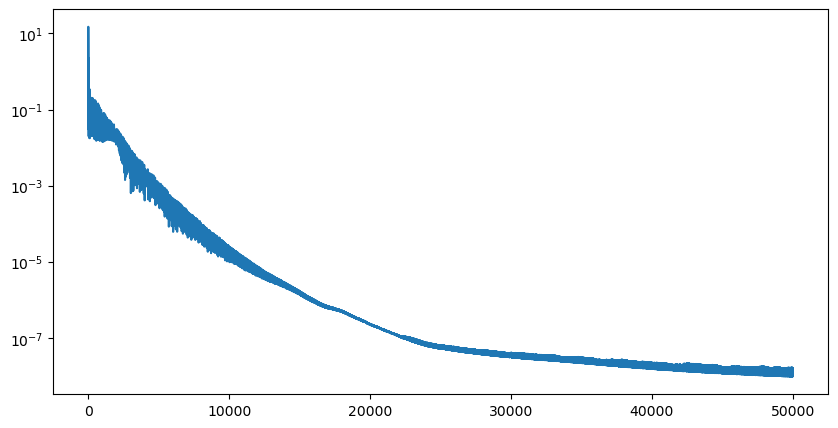

In [193]:
print(f"[Best][Epoch: {bep}] Train loss: {ls}") 
plt.figure(figsize=(10, 5))
plt.plot(loss_graph)
plt.yscale('log')
plt.show()

### 5. Inference Session

In [194]:
pinn.load_state_dict(torch.load('./'+eq+'_1d.pth'))

<All keys matched successfully>

In [195]:
# def hj_exact(x,y): #use this if i.c. is L2
#     f = torch.zeros(256, 101)
#     for j in range(len(y)):
#         for i in range(len(x)):
#                 f[i,j] = x[i]**2/(2*y[j]+1)
#     return f

        
def hj_exact(x,y): #use this if i.c. is L1
    f = torch.zeros(256, 101)
    for j in range(len(y)):
        for i in range(len(x)):
            if torch.absolute(x[i])<y[j]:
                f[i,j] = 1/(2*y[j])*x[i]**2
            else:
                f[i,j] = torch.absolute(x[i])-y[j]/2
    return f

interval_x = torch.arange(0,1, 1/256)
# #print(interval_x)
interval_t = torch.arange(0,1, 1/100)
# #print(interval_t)

# interval = torch.stack((interval_x, interval_t), 1)
# print(interval)

#interval = torch.cartesian_prod(interval_x, interval_t)
#print(interval[0, 1])

#data = torch.tensor(list(map(f, interval_x, interval_t)))

def bshj_exact(X,T):
    M=torch.zeros(256,101)
    for j in range(len(T)):
        t=T[j]
        for i in range(len(X)):
            x=X[i]
            if 0<x and x<0.5*np.exp(-t):
                M[i,j] = 1/2+x*(1-np.exp(t))/t
            elif x>0.5*np.exp(t):
                M[i,j] =-1/2+x*(1-np.exp(-t))/t
            elif t==0:
                if x>0.5:
                    M[i,j]=x-0.5
                if x<=0.5:
                    M[i,j]=0.5-x
                
            else:
                M[i,j] = (2*x-np.log(x)-1-np.log(2))/(2*t)
    return M

# d = bshj_exact(interval_x, interval_t)



In [196]:
if eq =='bshj':
    t_test, x_test = data.bs_entropy_hj_generator(101, 256, typ='test')
    t = np.linspace(0.01,1, 101).reshape(-1,1)
    x = np.linspace(0.0001, 1, 256).reshape(-1,1)
    T = t.shape[0]
    N = x.shape[0]
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    d = bshj_exact(x.flatten(), t.flatten())
    Exact = d.cpu().numpy().reshape(N,T)
    err = u_pred[:,:-1]-Exact[:,:-1]
    
    
if eq == 'hj':       
    t_test, x_test = data.hj_generator(101, 256, typ='test')
    t = np.linspace(0, 1, 101).reshape(-1,1)
    x = np.linspace(-1, 1, 256).reshape(-1,1)
    T = t.shape[0]
    N = x.shape[0]
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)
    
    # reference data
    d = hj_exact(interval_x, interval_t)
    # Exact = np.real(data['usol']) 
    Exact = d.cpu().numpy().reshape(N,T)
    print(Exact.shape)
    # data = scipy.io.loadmat('./data/burgers_shock.mat')  
    # Exact = np.real(data['usol'])  
    err = u_pred[:,:-1]-Exact[:,:-1]
    
    
    

if eq == 'bg':       
    t_test, x_test = data.bg_generator(101, 256, typ='test')
    t = np.linspace(0, 1, 101).reshape(-1,1)
    x = np.linspace(-1, 1, 256).reshape(-1,1)
    T = t.shape[0]
    N = x.shape[0]
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    data = scipy.io.loadmat('./data/burgers_shock.mat')  
    Exact = np.real(data['usol'])  
    err = u_pred[:,:-1]-Exact
    
elif eq == 'ac':
    t = np.linspace(0, 1, 201).reshape(-1,1) # T x 1
    x = np.linspace(-1, 1, 513)[:-1].reshape(-1,1) # N x 1
    T = t.shape[0]
    N = x.shape[0]
    T_star = np.tile(t, (1, N)).T  # N x T
    X_star = np.tile(x, (1, T))  # N x T
    t_test = T_star.flatten()[:, None]
    x_test = X_star.flatten()[:, None]
    
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    data = scipy.io.loadmat('./data/AC.mat')
    Exact = np.real(data['uu'])
    err = u_pred-Exact

# print(u_pred)
err = np.linalg.norm(err,2)/np.linalg.norm(Exact,2)   
print(f"L2 Relative Error: {err}")

L2 Relative Error: 0.12439881265163422


### 6. Result Figures

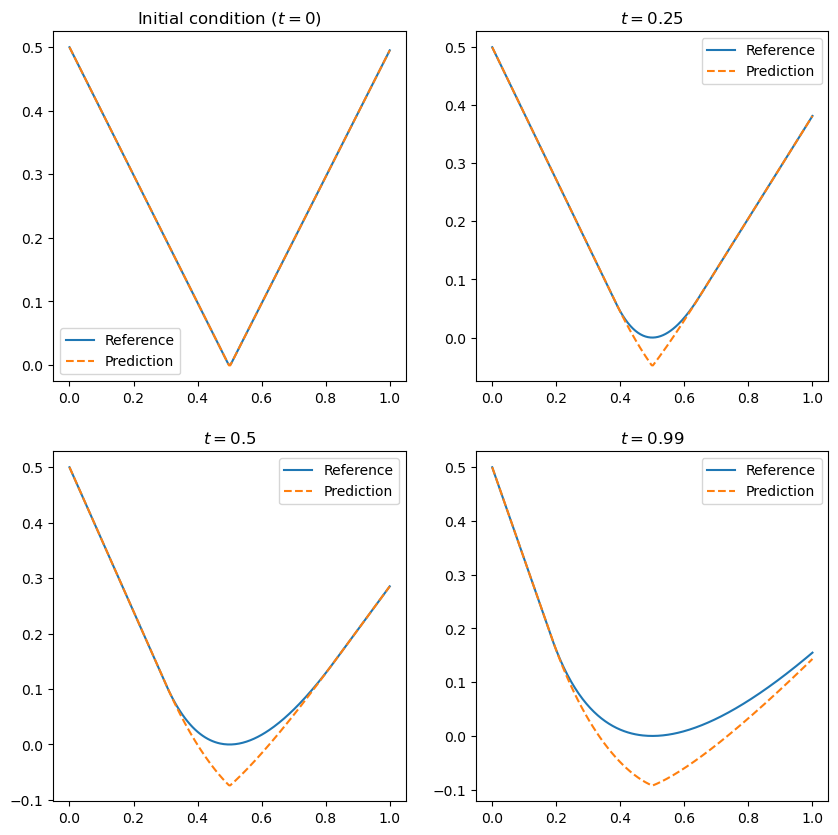

In [197]:
utils.resplot(x, t, t_data, x_data, Exact, u_pred)

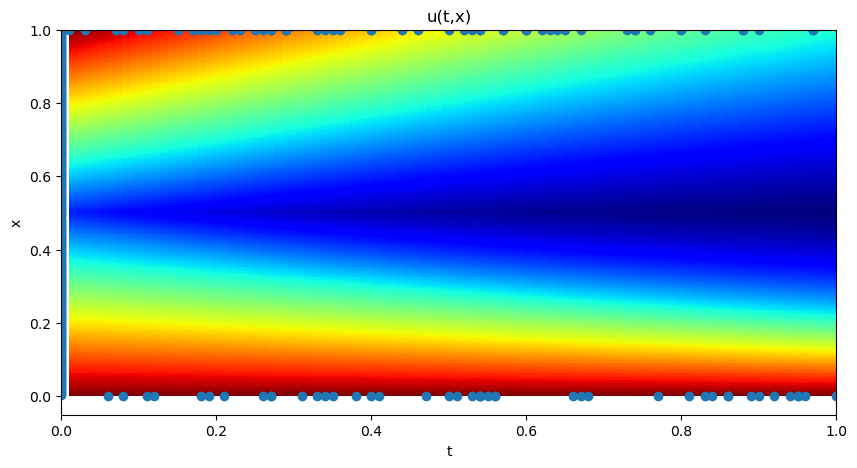

In [198]:
plt.figure(figsize=(10, 5))
plt.imshow(u_pred, interpolation='nearest', cmap='jet',
            extent=[t.min(), t.max(), x.min(), x.max()],
            origin='lower', aspect='auto')
# plt.clim(-1, 1)
# plt.ylim(-1,1)
plt.xlim(0,1)
plt.scatter(t_data, x_data)
plt.xlabel('t')
plt.ylabel('x')
plt.title('u(t,x)')
plt.show()